# Classificação de acordes

Este trabalho tem como objetivo a proposta e implementação (em Python) de um algoritmo capaz de classificar acordes em gravações de música. O método consiste em análises periódicas do espectro de frequência, associando as frequências a cada uma das 12 notas da escala cromática, gerando um histograma de notas para cada janela de tempo. A partir desse processo de classificação, encontramos possíveis tríades que podem ser formadas pelas notas que compõem o histograma. Qual seria o resutado deste algoritmo? Quão bem ele é capaz de classificar corretamente acordes em músicas gravadas?

# Introdução

## O espectro de frequências e _fast Fourier transform_

Em processamento digital de áudio, a análise no domínio da frequência, principalmente o de amplitude, pode trazer bastante informação sobre o sinal, mais do que a simples análise temporal.

In [1]:
import numpy as np
from scipy import fftpack
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
Fs = 44100
Tmax = 2
A3 = 440.0
E3 = 329.63
t = np.linspace(0, Tmax, Tmax*Fs)
s = 0.7*np.sin(2*np.pi*A3*t) + 0.3*np.sin(2*np.pi*E3*t)
ipd.Audio(s, rate=Fs)

(0.0, 0.025)

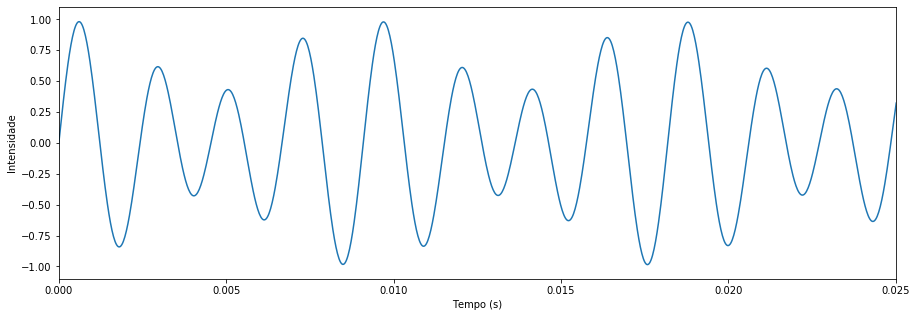

In [3]:
plt.figure(figsize=(15,5))
plt.plot(t, s)
plt.xlabel('Tempo (s)')
plt.ylabel('Intensidade')
plt.xlim(0.0, 0.025)

(300, 500)

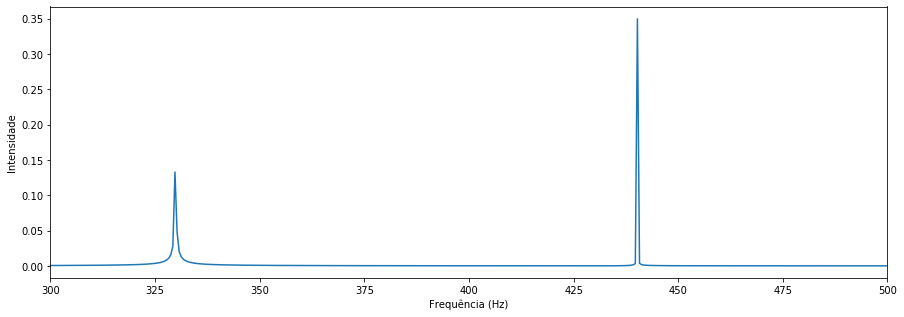

In [4]:
S = fftpack.fft(s)
S = S/len(S)
f = np.linspace(-Fs/2, Fs/2, len(S))
Splot = np.abs(fftpack.fftshift(S))
plt.figure(figsize=(15,5))
plt.plot(f, Splot)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Intensidade')
plt.xlim(300, 500)

## Análise tempo-frequência e _short-time Fourier transform_

É possível dividir as amostras de um sinal de áudio em janelas de tempo, de modo que possamos determinar o espectro periódico do sinal.

In [5]:
tchirp = np.linspace(0, 3, 3*Fs)
s = signal.chirp(tchirp, 200.0, 3, 1000.0, 'logarithmic')
ipd.Audio(s, rate=Fs)

(0, 1000)

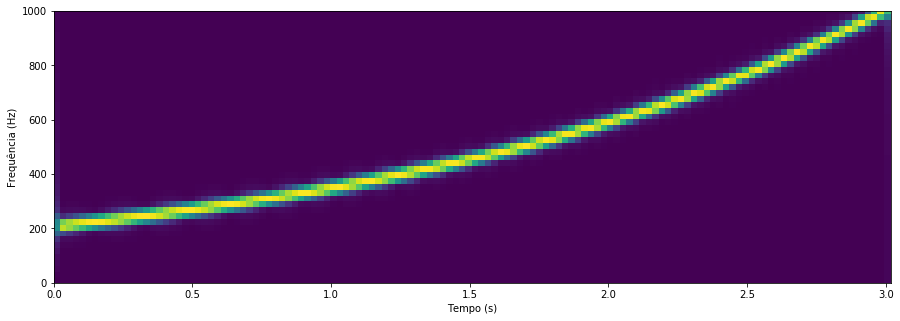

In [6]:
f, t, Stf = signal.stft(s, fs=Fs, nperseg=2048)
plt.figure(figsize=(15,5))
Stfplot = np.abs(Stf)
plt.pcolormesh(t, f, Stfplot)
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.ylim(0, 1000)

Note que, por conta da FFT aplicada em uma janela de aproximadamente 50ms, há uma imprecisão na medida de frequência vista por uma linha espessa no gráfico. Ao aumentar o tamanho dessa janela, obtemos maior precisão da frequência, mas perdemos informação temporal.

(0, 600)

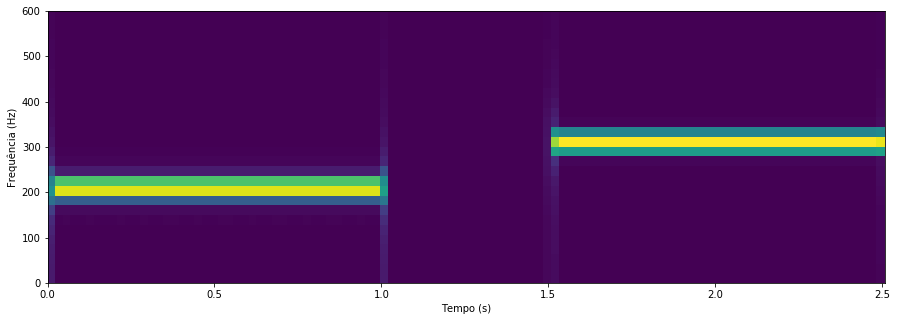

In [7]:
tsig = np.linspace(0, 1, Fs)
tsil = np.linspace(0, 0.5, int(0.5*Fs))
# 2 segundos de 200Hz, silencio e 2 segundos de 300Hz
s1 = np.sin(2*np.pi*200.0*tsig)
silent = 1e-7*tsil
s2 = np.sin(2*np.pi*300.0*tsig)
s = np.concatenate((s1, silent, s2))

f, t, Stf = signal.stft(s, fs=Fs, nperseg=2048)
plt.figure(figsize=(15,5))
Stfplot = np.abs(Stf)
plt.pcolormesh(t, f, Stfplot)
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.ylim(0, 600)

## Frequências e escala cromática

A escala cromática contém 12 notas com intervalos de semitons. Como duas oitavas consecutivas possuem a relação de dobro/metade da frequência, define-se a relação de frequência entre semitons:


$$ {ST}_{n} = 2^{1/12} \cdot {ST}_{n-1} = 2^{n/12} \cdot {ST}_{0} $$

Sendo $${ST}_{0} = 55Hz$$ o Lá Zero (A0). 

Podemos entender essa relação simétrica entre semitons desenhada por um círculo.

![](Pitch_class_space_David_Eppstein.png)
 
<p style="text-align: center;">Figura 1 - Escala cromática vista como um círculo (Autor: David Eppstein)</p>

Em termos de frequência, podemos associar as notas a pontos de uma curva helicoidal, cuja projeção destes pontos
obtém o círculo da figura 1, e a distância entre pontos da mesma projeção (o passo da hélice) cresce o dobro em relação à anterior.

![](chroma-helix2.png)

<p style="text-align: center;">Figura 2 - Escala cromática vista como uma helicoidal</p>

Vale ressaltar que muitos sistemas de afinações não usam esta escala simétrica de semitons.

# Metodologia

## Obtenção de notas do espectro de frequência

Passos seguidos:
 1. Relação de espectro (módulo ao quadrado) e tempo obtida pela STFT
 1. Para cada janela de tempo
  1. Determinar a frequência de centro pela equação
      $${ST}_{n} = 2^{n/12} \cdot {ST}_{0}$$
  1. Determinar os limites inferior e superior como
      $${ST}_{n} \pm 2.8\%$$
     Baseado na distância média entre duas frequências de semitons
  1. Somar em uma lista de 12 notas os valores das amostras entre os limites
      1. n = 0, 12, 24, ... em A
      1. n = 1, 13, 25, ... em A#
      1. n = 2, 15, 26, ... em B
      1. ...
  1. Parar quando chegar em 20 kHz (ou metade da frequência de amostragem, segundo teorema de Nyquist-Shannon)
  1. Normalizar a lista dividindo pela soma
 1. O retorno é uma tabela cujas linhas são as notas e as colunas são as janelas de tempo em que 
    se aplicou a STFT

In [8]:
import sys
sys.path.append("../src/")

from chroma import chromagram_stft
from chroma import chromaplot
import classifier

from scipy.io import wavfile


In [9]:
Fs, data = wavfile.read('../wav/ChromaticScaleUp.wav')
ipd.Audio(data, rate=Fs)

(0, 2000)

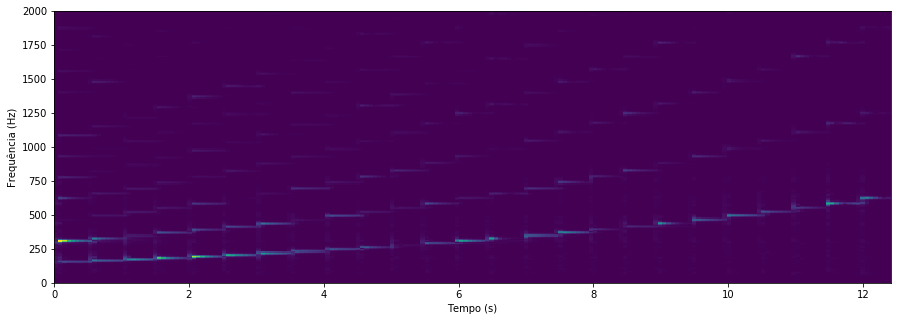

In [10]:
f, t, Stf = signal.stft(data, fs=Fs, nperseg=2048)
plt.figure(figsize=(15,5))
Stfplot = np.abs(Stf)
plt.pcolormesh(t, f, Stfplot)
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.ylim(0, 2000)

Text(0.5, 0, 'Tempo (s)')

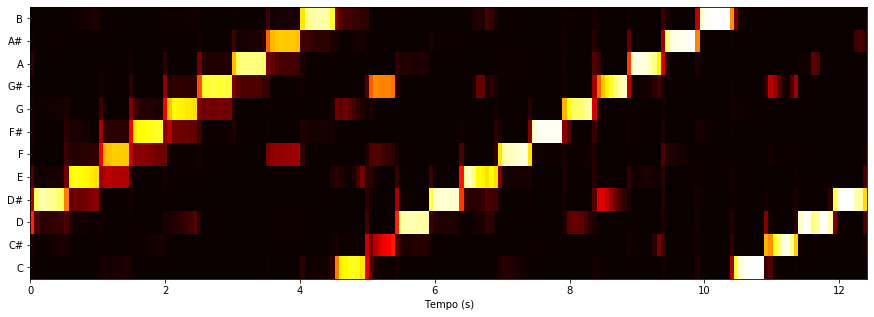

In [11]:
scale, t, Ch = chromagram_stft(data, rate=Fs)

plt.figure(figsize=(15,5))
chromaplot(t, scale, Ch)
plt.xlabel('Tempo (s)')


## Obtenção de um acorde

In [17]:
Fs, data = wavfile.read('../wav/CMajor2.wav', 44100)
ipd.Audio(data, rate=Fs)

(20, 2000)

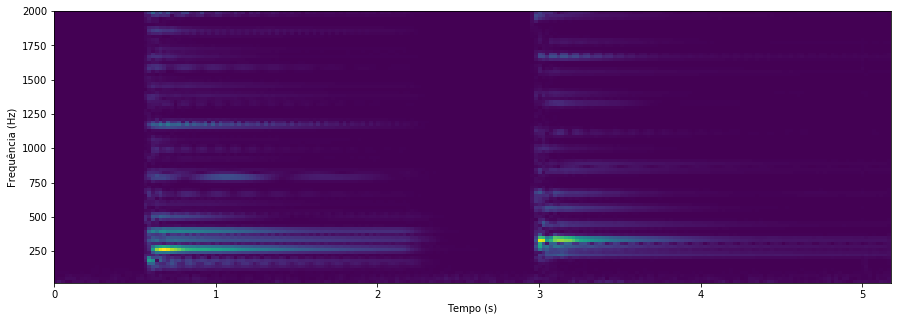

In [13]:
f, t, Stf = signal.stft(data, fs=Fs, nperseg=2048)
plt.figure(figsize=(15,5))
Stfplot = np.abs(Stf)
plt.pcolormesh(t, f, Stfplot)
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.ylim(20, 2000)

Text(0.5, 0, 'Tempo (s)')

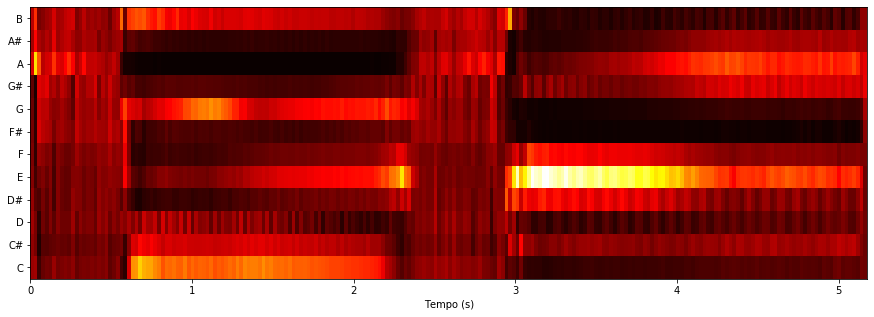

In [21]:
scale, t, Ch = chromagram_stft(data, rate=Fs)

plt.figure(figsize=(15,5))
chromaplot(t, scale, Ch)
plt.xlabel('Tempo (s)')

Text(0.5, 0, 'Tempo (s)')

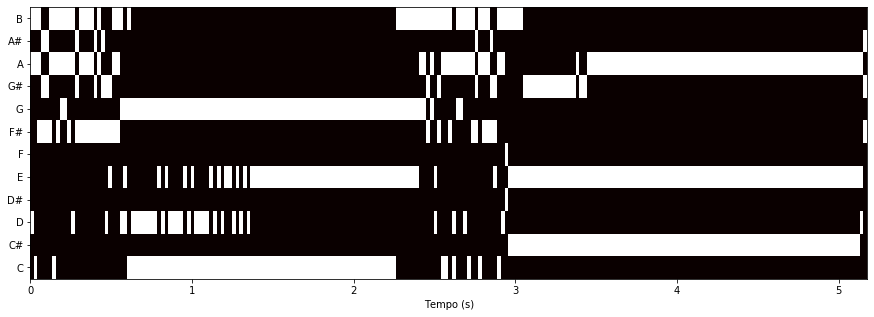

In [68]:
note_groups = classifier.get_note_list(data, rate=Fs)

# Plotting results
plottable_groups = np.zeros(shape=(12, len(note_groups)))
scale = [s for s in scale]
for i in range(len(note_groups)):
    for note in note_groups[i]:
        plottable_groups[scale.index(note), i] = 1
        
plt.figure(figsize=(15,5))
chromaplot(t, scale, plottable_groups)
plt.xlabel('Tempo (s)')

Text(0.5, 0, 'Tempo (s)')

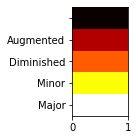

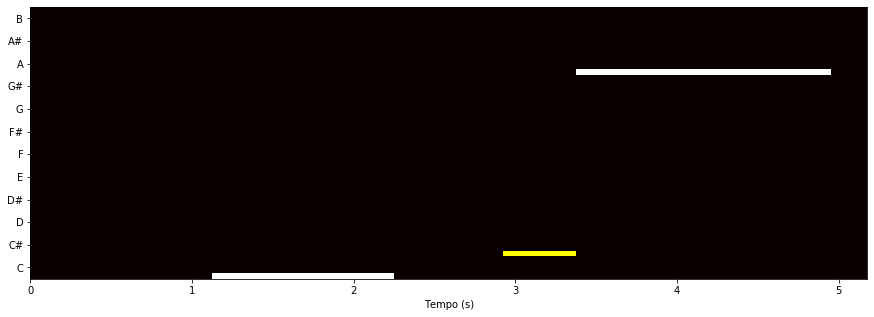

In [76]:
note_strings = classifier.chord_to_string(note_groups, scale)
chords = classifier.compress_result(note_strings, window=10)

# Plotting results
plottable_chords = np.zeros(shape=(len(chord_list), len(chords)))
for i in range(len(chords)):
    if chords[i]:
        if chords[i][-1] == 'm':
            plottable_chords[chord_list.index(chords[i][:-1]), i] = 3
        elif chords[i][-1] == 'd':
            plottable_chords[chord_list.index(chords[i][:-1]), i] = 2
        elif chords[i][-1] == '+':
            plottable_chords[chord_list.index(chords[i][:-1]), i] = 1
        else:
            plottable_chords[chord_list.index(chords[i]), i] = 4

# Plot chord weight subtitle
plt.figure(figsize=(1,2))
chromaplot([0,1], ['Major', 'Minor', 'Diminished', 'Augmented', ''], [[4], [3], [2], [1], [0]])

# Plots found chords
plt.figure(figsize=(15,5))
chromaplot(np.linspace(t[0], t[-1], num=int(len(t)/4)), scale, plottable_chords)
plt.xlabel('Tempo (s)')